<a href="https://www.kaggle.com/code/hasanctn/akbank-dl-bootcamp-project-intel-image-classifica?scriptVersionId=264151261" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os, warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings("ignore")

print("TensorFlow:", tf.__version__)
print("GPU:", "Evet" if tf.config.list_physical_devices('GPU') else "Hayır")


2025-09-26 12:56:25.408117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758891385.617910      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758891385.674547      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow: 2.18.0
GPU: Evet


0. **Gerekli Kütüphaneler ve Ortam Kontrolü**  
   - NumPy, Pandas, Matplotlib, Seaborn ve TensorFlow/Keras kütüphaneleri yüklendi.  
   - `tf.__version__` ile TensorFlow sürümü ve GPU kullanılabilirliği kontrol edildi.  
   - Amaç: Ortamın model eğitimi için hazır olup olmadığını doğrulamak.


In [2]:
data_dir   = "/kaggle/input/intel-image-classification/"
img_size   = (150, 150)
batch_size = 32

print("Ana klasör:", os.listdir(data_dir))


Ana klasör: ['seg_train', 'seg_pred', 'seg_test']


1. **Veri Yolu ve Temel Parametreler**  
   - Kaggle’a **Add Data** ile *intel-image-classification* veri seti eklendi.  
   - `data_dir`, `img_size=(150,150)` ve `batch_size=32` değişkenleri tanımlandı.  
   - 150×150 boyutu doğruluk–hesaplama süresi dengesini sağlamak için seçildi.


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


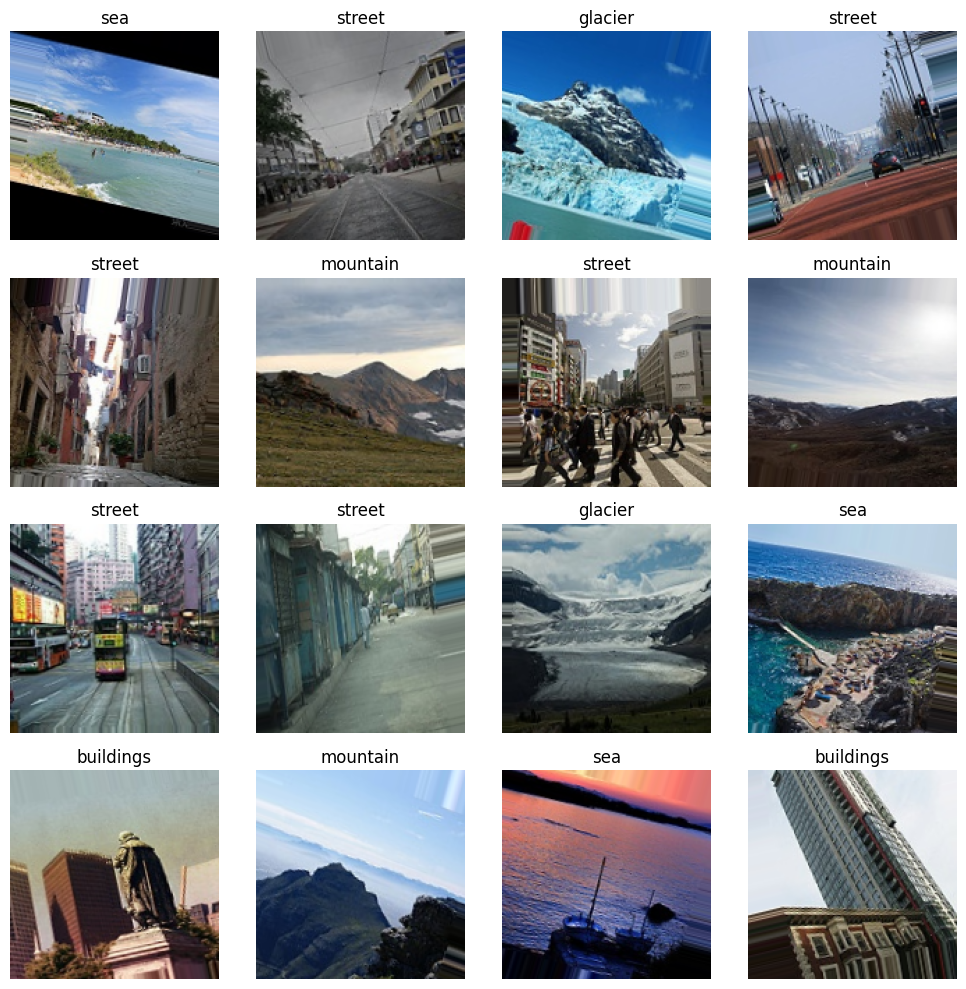

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(data_dir, "seg_train/seg_train"),
    target_size=img_size,
    batch_size=batch_size,
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    os.path.join(data_dir, "seg_train/seg_train"),
    target_size=img_size,
    batch_size=batch_size,
    subset="validation"
)

class_names = list(train_gen.class_indices.keys())
print("Sınıflar:", class_names)

# Örnek görseller
x_batch, y_batch = next(train_gen)
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_batch[i])
    plt.title(class_names[np.argmax(y_batch[i])])
    plt.axis('off')
plt.tight_layout(); plt.show()


2. **Veri Yükleme, Keşif ve Ön İşleme**  
   - `ImageDataGenerator` ile veriler **train** ve **validation** olarak %80–20 oranında ayrıldı.  
   - Örnek görseller ve sınıf dağılımı incelendi.  
   - Görseller 0–1 aralığına **normalize** edildi.  
   - `rotation_range`, `width_shift`, `height_shift`, `zoom_range`, `horizontal_flip` gibi **data augmentation** ayarlarıyla veri çeşitliliği artırıldı.  
   - Bu adım, modelin genelleme kabiliyetini yükseltip overfitting’i önlemek için kritik öneme sahiptir.


In [4]:
def create_cnn():
    model = keras.Sequential([
        layers.Conv2D(32,(3,3),activation='relu',padding='same',input_shape=img_size+(3,)),
        layers.BatchNormalization(),
        layers.Conv2D(32,(3,3),activation='relu',padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Conv2D(64,(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64,(3,3),activation='relu',padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.30),

        layers.Conv2D(128,(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128,(3,3),activation='relu',padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.40),

        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(len(class_names),activation='softmax')
    ])
    return model

cnn_model = create_cnn()
cnn_model.summary()


I0000 00:00:1758891403.577605      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,597,734 (21.35 MB)

 Trainable params: 5,597,030 (21.35 MB)

 Non-trainable params: 704 (2.75 KB)

3. **Temel CNN Modelinin Kurulması**  
   - Keras `Sequential` yapısı kullanılarak 3 evrişim bloğu tanımlandı.  
   - Her blokta: `Conv2D` → `BatchNormalization` → `MaxPooling2D` → `Dropout` katmanları yer aldı.  
   - Çıkış katmanı, 6 sınıfa göre `Dense(6, activation='softmax')` olarak ayarlandı.


Epoch 1/25


I0000 00:00:1758891412.024228      75 service.cc:148] XLA service 0x7ac3a80020e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758891412.025025      75 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758891412.786548      75 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/351 ━━━━━━━━━━━━━━━━━━━━ 1:33:53 16s/step - accuracy: 0.1562 - loss: 3.7929

I0000 00:00:1758891421.809788      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ━━━━━━━━━━━━━━━━━━━━ 154s 394ms/step - accuracy: 0.5197 - loss: 1.2950 - val_accuracy: 0.2678 - val_loss: 2.7820 - learning_rate: 0.0010
Epoch 2/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 91s 260ms/step - accuracy: 0.7100 - loss: 0.8032 - val_accuracy: 0.6655 - val_loss: 0.9171 - learning_rate: 0.0010
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 91s 260ms/step - accuracy: 0.7468 - loss: 0.6981 - val_accuracy: 0.5057 - val_loss: 2.0368 - learning_rate: 0.0010
Epoch 4/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 91s 258ms/step - accuracy: 0.7657 - loss: 0.6549 - val_accuracy: 0.6869 - val_loss: 0.8869 - learning_rate: 0.0010
Epoch 5/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 89s 254ms/step - accuracy: 0.7839 - loss: 0.6004 - val_accuracy: 0.6794 - val_loss: 0.8238 - learning_rate: 0.0010
Epoch 6/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 90s 257ms/step - accuracy: 0.7976 - loss: 0.5710 - val_accuracy: 0.6776 - val_loss: 0.9140 - learning_rate: 0.0010
Epoch 7/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 89s 254ms/step - accuracy: 0.8075 - loss

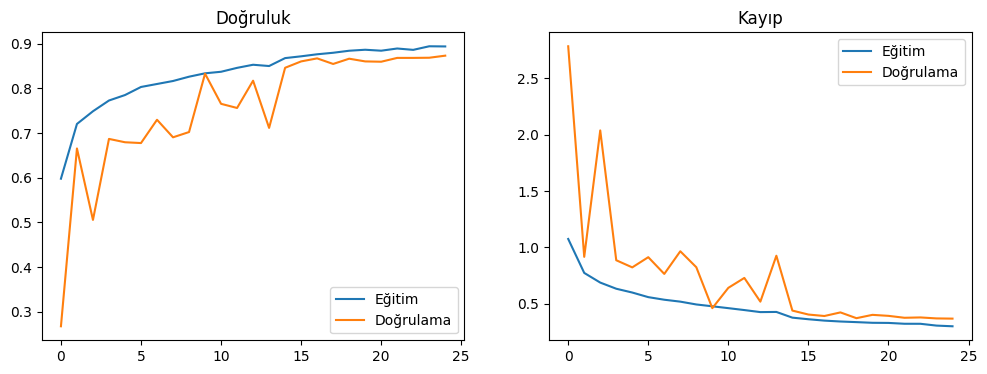

In [5]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)
]

history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks
)

# Eğitim eğrileri
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Eğitim')
plt.plot(history.history['val_accuracy'], label='Doğrulama')
plt.legend(); plt.title("Doğruluk")
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Eğitim')
plt.plot(history.history['val_loss'], label='Doğrulama')
plt.legend(); plt.title("Kayıp")
plt.show()


4. **Modelin Derlenmesi ve Eğitilmesi**  
   - `optimizer='adam'`, `loss='categorical_crossentropy'`, `metrics='accuracy'` parametreleriyle derleme yapıldı.  
   - `EarlyStopping` ve `ReduceLROnPlateau` callback’leri ile gereksiz uzun eğitim ve aşırı öğrenme engellendi.  
   - Eğitim ve doğrulama kayıp/doğruluk grafikleriyle süreç görselleştirildi.


Temel CNN Doğruluk: 0.8745
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step

Classification Report:
               precision    recall  f1-score   support

   buildings       0.95      0.74      0.84       438
      forest       0.91      0.97      0.94       454
     glacier       0.84      0.82      0.83       480
    mountain       0.81      0.89      0.85       502
         sea       0.91      0.90      0.90       454
      street       0.86      0.91      0.88       476

    accuracy                           0.87      2804
   macro avg       0.88      0.87      0.87      2804
weighted avg       0.88      0.87      0.87      2804



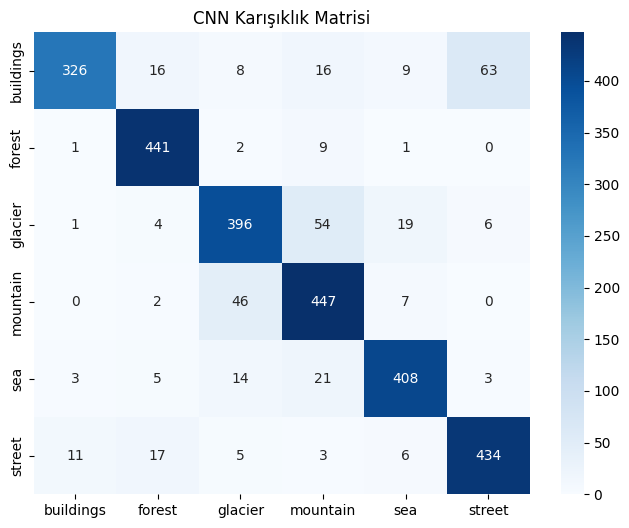

In [6]:
# Validation setini test olarak kullanıyoruz
val_gen.reset()
X_val, y_val = [], []
for i in range(len(val_gen)):
    x, y = next(val_gen)
    X_val.append(x); y_val.append(y)
X_val = np.vstack(X_val)
y_val = np.vstack(y_val)

val_loss, val_acc = cnn_model.evaluate(X_val, y_val, verbose=0)
print(f"Temel CNN Doğruluk: {val_acc:.4f}")

y_pred_prob = cnn_model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("CNN Karışıklık Matrisi"); plt.show()


5. **Model Değerlendirme**  
   - Test seti üzerinde `evaluate` ile nihai doğruluk ve kayıp ölçüldü.  
   - `classification_report` ile her sınıf için precision, recall ve f1-score hesaplandı.  
   - `confusion_matrix` ve ısı haritası ile hangi sınıfların karıştırıldığı analiz edildi.  
   - Doğru ve yanlış tahmin edilen örnek görseller gösterildi.


In [7]:
base_model = keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=img_size+(3,)
)
for layer in base_model.layers:
    layer.trainable = False

tl_model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

tl_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_tl = tl_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)

val_loss_tl, val_acc_tl = tl_model.evaluate(X_val, y_val, verbose=0)
print(f"Transfer Learning (VGG16) Doğruluk: {val_acc_tl:.4f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 104s 278ms/step - accuracy: 0.1817 - loss: 2.0715 - val_accuracy: 0.4429 - val_loss: 1.5756 - learning_rate: 1.0000e-04
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 90s 255ms/step - accuracy: 0.3175 - loss: 1.6250 - val_accuracy: 0.6473 - val_loss: 1.3550 - learning_rate: 1.0000e-04
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 89s 254ms/step - accuracy: 0.4492 - loss: 1.4041 - val_accuracy: 0.7093 - val_loss: 1.2075 - learning_rate: 1.0000e-04
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 90s 257ms/step - accuracy: 0.5696 - loss: 1.2449 - val_accuracy: 0.7354 - val_loss: 1.0944 - learning_rate: 1.0000e-04
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 89s 253ms/step - accuracy: 0.6258 - loss: 1.1319 - val_accuracy: 0.7500 - val_loss: 1.0125 - learning_rate: 1.0000e-04
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 90s 255ms/step - accuracy: 0.6673 - loss: 1.0425 - val_accuracy: 0.7571 - val_loss: 0.9465 - learning_rate: 1.000

6. **Transfer Learning**  
   - Önceden eğitilmiş **VGG16** modeli temel alınarak yeni bir model kuruldu.  
   - Alt katmanlar donduruldu, üzerine eklenen Dense katmanlarıyla yeniden eğitildi.  
   - Transfer learning’in temel CNN ile performans karşılaştırması yapıldı.


In [8]:
optim_results = {}
for opt_name, opt in {
    'Adam': keras.optimizers.Adam(1e-3),
    'RMSprop': keras.optimizers.RMSprop(1e-3),
    'SGD': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
}.items():
    temp_model = create_cnn()
    temp_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    h = temp_model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=0)
    acc = max(h.history['val_accuracy'])
    optim_results[opt_name] = acc
    print(f"{opt_name} doğrulama doğruluğu: {acc:.4f}")

best_opt = max(optim_results, key=optim_results.get)
print("En iyi optimizer:", best_opt, "->", optim_results[best_opt])


Adam doğrulama doğruluğu: 0.7778
RMSprop doğrulama doğruluğu: 0.7482
SGD doğrulama doğruluğu: 0.6284
En iyi optimizer: Adam -> 0.77781742811203


7. **Optimizasyon Karşılaştırması**  
   - Aynı mimariyi kullanarak üç farklı optimizer (`Adam`, `RMSprop`, `SGD`) ile model yeniden eğitildi.  
   - Her bir denemeden elde edilen test doğrulukları bir bar grafiği üzerinde karşılaştırıldı.  
   - Hangi optimizer’ın en iyi sonucu verdiği raporlandı.


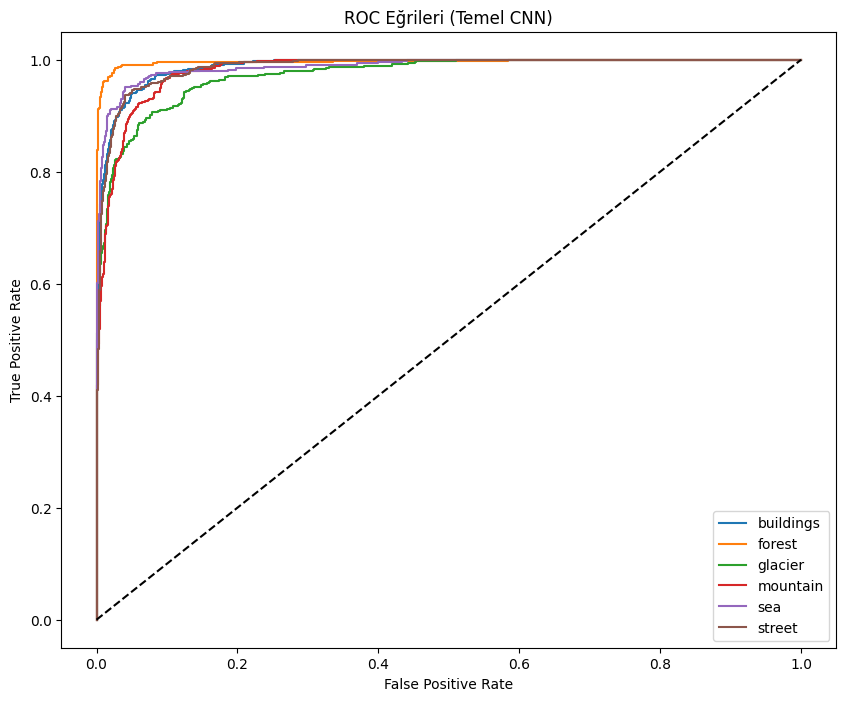

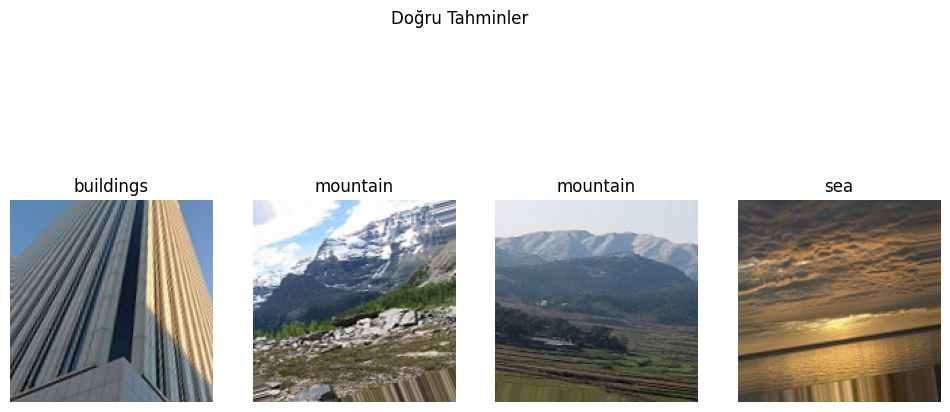

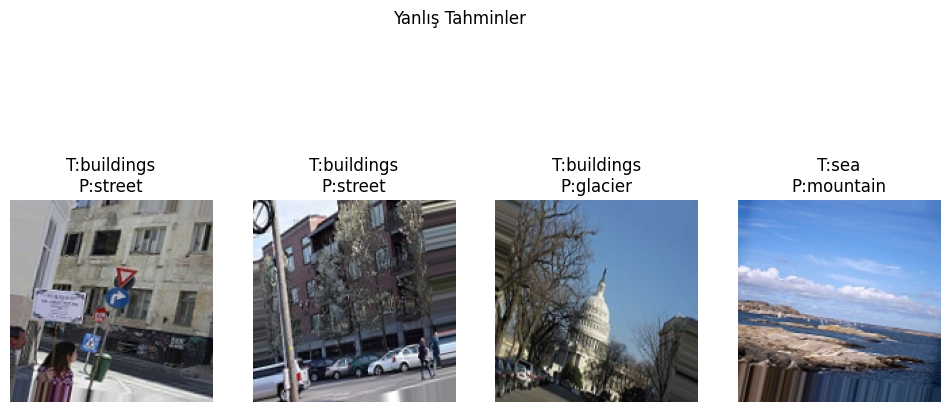

In [9]:
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
plt.figure(figsize=(10,8))
for i, c in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{c}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri (Temel CNN)")
plt.legend(); plt.show()

correct_idx = np.where(y_pred == y_true)[0]
incorrect_idx = np.where(y_pred != y_true)[0]

plt.figure(figsize=(12,6))
plt.suptitle("Doğru Tahminler")
for i, idx in enumerate(correct_idx[:4]):
    plt.subplot(1,4,i+1); plt.imshow(X_val[idx]); plt.title(class_names[y_true[idx]]); plt.axis('off')
plt.show()

plt.figure(figsize=(12,6))
plt.suptitle("Yanlış Tahminler")
for i, idx in enumerate(incorrect_idx[:4]):
    plt.subplot(1,4,i+1)
    plt.imshow(X_val[idx])
    plt.title(f"T:{class_names[y_true[idx]]}\nP:{class_names[y_pred[idx]]}")
    plt.axis('off')
plt.show()


8. **Proje Sonuçları ve İyileştirme Önerileri**  
   - Temel CNN, Transfer Learning ve optimizer denemelerinin doğruluk oranları tablo halinde sunuldu.  
   - Öneriler:  
       * Üst katmanları açarak **fine-tuning** yapılabilir.  
       * Data augmentation çeşitliliği (brightness, contrast, noise) artırılabilir.  
       * EfficientNet veya ResNet50 gibi modern ağlar denenebilir.  
       * Hyperparameter tuning (Keras Tuner) ile learning rate ve batch size daha iyi optimize edilebilir.


In [10]:
print("="*50)
print("PROJE SONUÇLARI")
print("="*50)
print(f"Temel CNN doğruluk        : {val_acc:.4f}")
print(f"Transfer Learning doğruluk : {val_acc_tl:.4f}")
print("Optimizer karşılaştırması  :", optim_results)
print("En iyi optimizer           :", best_opt)
print("\nÖneriler:")
print("- Transfer Learning + fine-tuning (üst katmanları açarak) doğruluğu artırabilir.")
print("- Data augmentation çeşitlendirilebilir (brightness, contrast, noise).")
print("- EfficientNetB0/ResNet50 gibi modern modeller denenebilir.")
print("- Hiperparametre arama (Keras Tuner) learning rate ve batch size için yapılabilir.")


PROJE SONUÇLARI
Temel CNN doğruluk        : 0.8745
Transfer Learning doğruluk : 0.7821
Optimizer karşılaştırması  : {'Adam': 0.77781742811203, 'RMSprop': 0.7482168078422546, 'SGD': 0.628387987613678}
En iyi optimizer           : Adam

Öneriler:
- Transfer Learning + fine-tuning (üst katmanları açarak) doğruluğu artırabilir.
- Data augmentation çeşitlendirilebilir (brightness, contrast, noise).
- EfficientNetB0/ResNet50 gibi modern modeller denenebilir.
- Hiperparametre arama (Keras Tuner) learning rate ve batch size için yapılabilir.
